In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="../css/custom.css">

# Recurrent Neural Networks for Sentiment Classification


Feedforward networks learn their parameters once and have a fixed state, so they cannot take context in the input data into account.

Recurrent neural networks (RNNs) also learn their parameters once, but keep a state depending on the sequence they have seemed so far.

This makes RNNs well suited for problems with sequences, like converting speech to text: translation of a word can be helped by knowing the words that came before.

![footer_logo](../images/logo.png)

## Goal

In this exercise we'll apply a RNN for sentiment classification.
We'll get some reviews from movies and try to classify if they have a positive or negative sentiment.

## Program

- [Introducing the dataset]()
- [Preprocessing the data]()
- [The model]()
- [Extension exercises]()
    - [Compare against a baseline model]()
    - [Minimum viable network]()
    - [Visualising the embeddings]()
    - [Transfer learning (Glove)]()

---
## Data

Like many other libraries, `keras` includes some standard datasets to play around with.
We'll use the IMDB dataset. This section shows what this dataset contains.

From the [website](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification) (emphasis ours): 

> "Dataset of __25,000 movies reviews from IMDB, labeled by sentiment (positive/negative)__. Reviews have been preprocessed, and __each review is encoded as a sequence of word indexes__ (integers). For convenience, __words are indexed by overall frequency__ in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".
>
> As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.


We'll load reviews with only the 20,000 most frequent words:

In [3]:
from tensorflow.keras.datasets import imdb

NUM_WORDS = 20000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)

print("Loading data...")
print(len(x_train), "train sequences")
print(len(x_test), "test sequences")

Loading data...
25000 train sequences
25000 test sequences


In [19]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,

In [20]:
x_test[0]

[1,
 591,
 202,
 14,
 31,
 6,
 717,
 10,
 10,
 18142,
 10698,
 5,
 4,
 360,
 7,
 4,
 177,
 5760,
 394,
 354,
 4,
 123,
 9,
 1035,
 1035,
 1035,
 10,
 10,
 13,
 92,
 124,
 89,
 488,
 7944,
 100,
 28,
 1668,
 14,
 31,
 23,
 27,
 7479,
 29,
 220,
 468,
 8,
 124,
 14,
 286,
 170,
 8,
 157,
 46,
 5,
 27,
 239,
 16,
 179,
 15387,
 38,
 32,
 25,
 7944,
 451,
 202,
 14,
 6,
 717]

`x_train` and `x_test` are `numpy.ndarray`'s containing list of sequences.

A few examples are show below: the samples don't have the same length and are encoded by integers.

In [4]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,

This may be a valid way to represent text for machines, but it's not really usefull for humans.
Let's try to get the original text back.

The `imdb` module ships with a function `get_word_index()` to decode the integers to words, but we'll have to do some extra work: there are some special words for that are not the word index.
See the arguments `start_char`, `oov_char` and `index_from` of the function `imdb.load_data()` for more details.

In [5]:
INDEX_FROM = 3  # First actual word.

word_index = imdb.get_word_index()
word_to_index = {k: (v + INDEX_FROM) for k, v in word_index.items()}
# Add special words.
word_to_index["<PAD>"] = 0  # Padding
word_to_index["<START>"] = 1  # Starting of sequence
word_to_index["<UNK>"] = 2  # Unknown word

index_to_word = {v: k for k, v in word_to_index.items()}

With our dictionary `index_to_word` we can display the original reviews:

In [7]:
I_SHOW = 4

" ".join([index_to_word[w] for w in x_train[I_SHOW]])

"<START> worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the <UNK> and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life"

In [ ]:
x_train[4]

### <mark> Exercise 

Play around with `I_SHOW` and read some other reviews!

## Preprocessing

The previous section showed that the text was encoded by integers, but we need to do some more processing: `keras` needs all sequences (/reviews) to be of equal length.

We can choose to pad all sequences to the longest length, or we can choose a maximum review length and cut longer reviews.
We'll cut reviews after `MAXLEN=80` words and pad them if needed: 

In [8]:
from tensorflow.keras.preprocessing import sequence

MAXLEN = 80

X_train = sequence.pad_sequences(x_train, maxlen=MAXLEN)
X_test = sequence.pad_sequences(x_test, maxlen=MAXLEN)

print("Size of X_train", X_train.shape)
print("Size of X_test", X_test.shape)

Size of X_train (25000, 80)
Size of X_test (25000, 80)


Is this a valid threshold?

The figure below shows that we'll be cutting most texts and padding only some.
However, this can be fine: most of the sentiment could be in the first 80 words.
If we find out that it's not enough, we'll come back and increase the text length!

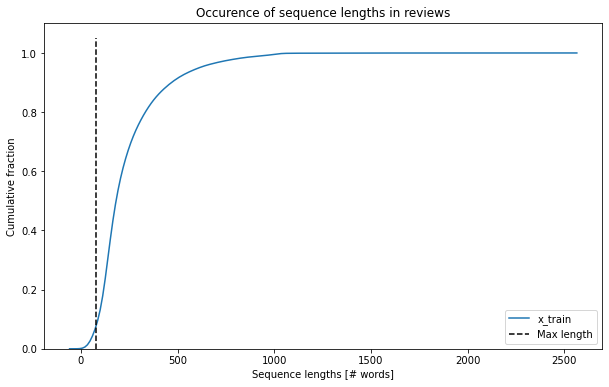

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

lengths = [len(s) for s in x_train]

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(lengths, cumulative=True, label="x_train", ax=ax)
ax.plot((80, 80), ax.get_ylim(), "--k")
ax.set_xlabel("Sequence lengths [# words]")
ax.set_ylabel("Cumulative fraction")
ax.set_title("Occurence of sequence lengths in reviews")
ax.legend(["x_train", "Max length"])

We're now done with the preprocessing!
In our training set we have 25000 reviews of 80 words (some of the padded).
All words are encoded by integers:

In [10]:
print("Size of X_train:", X_train.shape)

X_train[3, :]

Size of X_train: (25000, 80)


array([    2,    14,   280,    13,   219,     4,     2,   431,   758,
         859,     4,   953,  1052, 12283,     7,  5991,     5,    94,
          40,    25,   238,    60,     2,     4, 15812,   804,     2,
           7,     4,  9941,   132,     8,    67,     6,    22,    15,
           9,   283,     8,  5168,    14,    31,     9,   242,   955,
          48,    25,   279,     2,    23,    12,  1685,   195,    25,
         238,    60,   796, 13713,     4,   671,     7,  2804,     5,
           4,   559,   154,   888,     7,   726,    50,    26,    49,
        7008,    15,   566,    30,   579,    21,    64,  2574],
      dtype=int32)

---
## The model

Now we're done with all the data manipulation, what is our neural network going to look like?

Our initial model will consist of three layers: an embedding layer, a recurrent layer and a dense layer.
The embedding layer learns the relations between words, the recurrent layer learns what the document is about and the dense layer translates that to sentiment.

### 1 Embedding layer

The embedding layer will embed our original word vectors in a dense, lower-dimensional space.


Embeddings can capture __semantic information__ about words and their relationships to one another. 
Certain directions in the vector space embed certain semantic relationships such as male-femal, verb-tense and country-capital relationships between words.

<img src="../images/nlp/linear-relationships.png" alt="Drawing" style="width: 90%;"/>

> Source: https://www.tensorflow.org/tutorials/word2vec

We will build an embedding layer in Keras using `keras.layers.Embedding`. Keras can learn this layer for you, but you can also pretrained embeddings generated by others.
More on this later.

### 2 Recurrent layer

__Recurrent Neural Nets__ naturally deal with word order because they can go over a __sequence__ of words and keep a __memory__ of the information that has been calculated so far.

This could help when trying to assign sentiment to sentences, as shown in the figure below.
A word can trigger a sentiment that carries on for one or multiple sentences.

<img src="../images/nlp/sentiment-neuron.gif" style="width: 75%;"/>


> Source: [Unsupervised Sentiment Neuron](https://blog.openai.com/unsupervised-sentiment-neuron/)

If we'd be interested in __understanding a document__ like in the previous example, we could use the following architecture:

<img src="../images/nlp/rnn-architecture.png" style="width: 75%;"/>

> Source: [Goodfellow, 2016]

The left side of the figure shows a short-hand of the neural network, the right side shows the unrolled version.

At each time-step, the input is the output of the previous time-step $\mathbf{h}^{(t-1)}$ and a new input word vector $\mathbf{x}^{(t)}$.

Over time we adjust our idea of the document $\mathbf{h}^{(t)}$ until we've seen all words in the document.

This is illustrated in the figure below: we get a new word vector at each time-step and __carry over a score__. The final score $\mathbf{h}^{(T)}$ represents what the neural network has learned about the document after having seen every word. We will use the final score to detect the sentiments of the text.

![center](../images/rnn/rnn_many_to_one.jpeg)

We'll use a specific kind of recurrent layer: a LSTM.
The Long Short Term Memory neuron are able to learn long-term dependencies and often perform better than standard RNNs.

![center three_quarters](../images/lstm/LSTM_overview.png)
Read [this blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) if you'd like more info.

The LSTM layer can be found in `keras.layers.LSTM`.

### 3 Dense layer

The first layer learns a good representation of words, the second learns to combine words in a single idea, and the final layer turns this idea into a classification.

We will use a simple dense layer from `keras.layers.Dense` that transforms the idea vectors into a 0 or 1.
The layer will consist of a single neuron that takes all connections and outputs 0 or 1.

### Implementing the model

Now that we now how the architecture looks like and we have our data in `X_train` and `X_test`, it's time to build a model.

### <mark> Exercise: LSTM for sentiment classification
    
<img src="../images/nlp/m_lstm_sentiment.png" width="500"/>

> * Build a sequential model with three layers: embedding, LSTM and dense layers. 
>     * Don't make the embedding layer *larger than* 200 units. Use `NUM_WORDS` as the vocabulary size.
>     * Use *at most* 256 LSTM units. Play around with parameters `dropout` and `recurrent_dropout`.
> * Compile the model with `'binary_crossentropy'` as the loss and use `'accuracy'` as validation metric.
> * Add callbacks to the fitting: use `keras.callbacks.ModelCheckpoint()` and `keras.callbacks.EarlyStopping()`.
> * Reasonable test scores are 0.42 for the binary cross-entropy and and 0.81 for the accuracy.

In [14]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,

In [ ]:
# %load ../answers/sentiment_lstm.py
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM

# Make our model.
model = Sequential()
model.add(Embedding(NUM_WORDS, 32))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          640000    
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 722,561
Trainable params: 722,561
Non-trainable params: 0
_________________________________________________________________


In [17]:
640000 / 32

20000.0

In [18]:
NUM_WORDS

20000

In [12]:
# Callbacks.
checkpoint = callbacks.ModelCheckpoint(
    filepath="../output/imdb_lstm.h5", verbose=1, save_best_only=True
)
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=2, verbose=0, mode="auto"
)

# Compile and train.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, early_stopping],
)

score, acc = model.evaluate(X_test, y_test, batch_size=64)

print("Test score:", score)
print("Test accuracy:", acc)

2021-12-17 14:51:18.055535: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
391/391 [==============================] - ETA: 0s - loss: 0.4606 - accuracy: 0.7672
Epoch 00001: val_loss improved from inf to 0.35820, saving model to ../output/imdb_lstm.h5
391/391 [==============================] - 46s 114ms/step - loss: 0.4606 - accuracy: 0.7672 - val_loss: 0.3582 - val_accuracy: 0.8418
Epoch 2/20
391/391 [==============================] - ETA: 0s - loss: 0.2774 - accuracy: 0.8871
Epoch 00002: val_loss did not improve from 0.35820
391/391 [==============================] - 44s 114ms/step - loss: 0.2774 - accuracy: 0.8871 - val_loss: 0.3605 - val_accuracy: 0.8411
Epoch 3/20
391/391 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9186
Epoch 00003: val_loss did not improve from 0.35820
391/391 [==============================] - 11s 27ms/step - loss: 0.4313 - accuracy: 0.8296
Test score: 0.4312891364097595
Test accuracy: 0.8295599818229675


If you reached the benchmarks, you've succesfully trained a recurrent neural network for text classification!

The next section gives some pointers what to do next.

---
## Extension exercises

We've only touched the surface on applying RNNs to text.
This section contains some more exercises to deepen your understanding.

### <mark>Exercise: Baseline

This dataset is small, so might not really benefit from the complexity from deep learning.
> Use [`sklearn`](http://scikit-learn.org/stable/) to create a baseline: create a `Pipeline` using the `TfidfVectorizer()` and `BernoulliNB()` 
> What's your best score?

Hint:
> Use `X_train_translated` and `X_test_translated` from below; `TfidfVectorizer()` works better with real strings than integers.
> You can still use `y_train` and `y_test`.

In [ ]:
# Convert indices to text.
X_train_translated = [" ".join(index_to_word[w] for w in s) for s in x_train]
X_test_translated = [" ".join(index_to_word[w] for w in s) for s in x_test]

In [ ]:
# %load ../answers/sentiment_sklearn.py

### <mark>Exercise: Minimum Viable Network

You probably don't need a big network for this small dataset: there's not enough data to learn really complex relations.
>What's the smallest network you still get good results with?

In [ ]:
# %load ../answers/sentiment_mvn.py


### <mark>Exercise: Visualizing Embeddings

We explained previously that the embeddings could learn relations between words.
    
However, we didn't prove this for this solution: we just provided an architecture for the network and told the network to learn sentiment.
    
This means that it didn't necessarily use the embedding to learn a representation that makes sense to us: everything was conditioned on sentiment classfication.

>Visualize the embeddings: are they any good?
> * Get the weights from the right layer:
    * See the attribute `.layers` of the network.
    * Use the method `.get_weights()` of the layer.
> * Use [TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to map the weights into a 2D representation.

In [ ]:
# %load ../answers/sentiment_tsne.py


### <mark> Exercise: Transfer Learning

Instead of training the embeddings, you can use word embeddings pretrained on a large corpus.

This allows you to leverage complex relations learned from large corpora on your smaller datasets.
>
> - Read [this Keras blog](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
> - Rerun your model using word embeddings from GloVe. Note that not all words may be present, so you'll have to do some preprocessing.

Does it improve your model?

--- 
## Summary

In this notebook we used RNNs to sequentially process word embeddings, so that we could perform sentiment classification on movie reviews.